In [1]:
import torch
from torchvision import models

In [ ]:
# get the "features" portion of VGG19 (we will not need the "classifier" portion)
vgg = models.vgg19(pretrained=True)

In [3]:
vgg=vgg.features
print(vgg)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [4]:
# freeze all VGG parameters since we're only optimizing the target image
for param in vgg.parameters():
    param.requires_grad_(False)

In [ ]:
# move the model to GPU, if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg.to(device)

# Prepocess image

In [6]:
from PIL import Image
from torchvision import transforms as transforms

In [7]:
def preprocess(img_path, max_size=500):


    image = Image.open(img_path).convert('RGB')

    # large images will slow down processing
    if max(image.size) > max_size:
        size = max_size
    else:
        size = max(image.size)



    img_transform = transforms.Compose([
                        transforms.Resize(size),
                        transforms.ToTensor(),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225])
    ])

    # discard the transparent, alpha channel (that's the :3) and add the batch dimension
    image = img_transform(image)
    image=image.unsqueeze(0)   #(3,224,224)-->(1,3,224,224)
    return image

In [11]:
content_p=preprocess('https://github.com/Rutvik1727/Neural-Style-Transfer/blob/main/Images/img%20(1).jpg')
style_p=preprocess('https://github.com/Rutvik1727/Neural-Style-Transfer/blob/main/Images/img%20(2).jpg')

In [12]:
content_p=content_p.to(device)
style_p=style_p.to(device)

In [13]:
print("content shape",content_p.shape)
print("style shape",style_p.shape)

content shape torch.Size([1, 3, 256, 341])
style shape torch.Size([1, 3, 256, 341])


# Deprocess image

In [14]:
import numpy as np
import matplotlib.pyplot as plt

In [15]:
# and converting it from a Tensor image to a NumPy image for display
def deprocess(tensor):

    image = tensor.to("cpu").clone()
    image = image.numpy()
    image=image.squeeze(0)  #(1,3,224,224)-->(3,224,224)
    image = image.transpose(1,2,0)  #(3,224,224)-->(224,224,3)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    image = image.clip(0, 1)

    return image

In [16]:
content_d=deprocess(content_p)
style_d=deprocess(style_p)

In [17]:
print("content shape",content_d.shape)
print("style shape",style_d.shape)

content shape (256, 341, 3)
style shape (256, 341, 3)


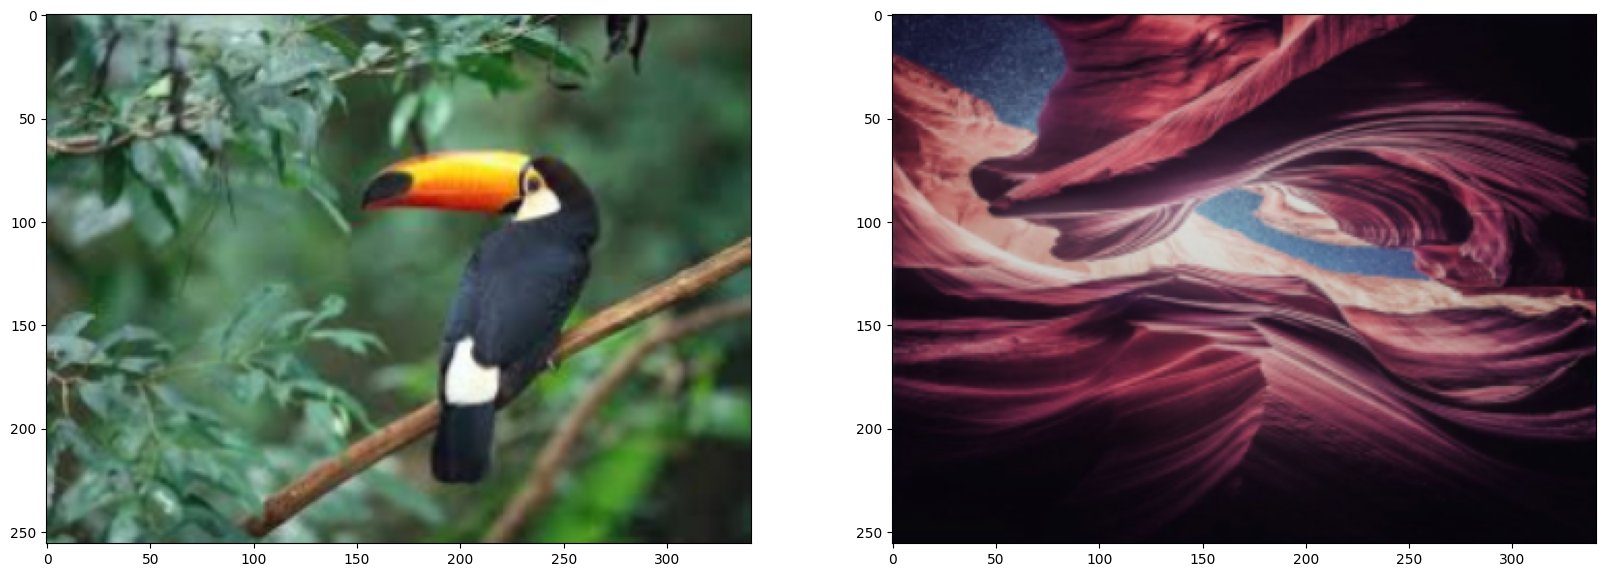

In [18]:
# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))
# content and style ims side-by-side
ax1.imshow(content_d)
ax2.imshow(style_d)

#Get content,stylefeatures and create gram matrix

In [19]:
def get_features(image, model):


    ## TODO: Complete mapping layer names of PyTorch's VGGNet to names from the paper
    ## Need the layers for the content and style representations of an image

    layers = {'0': 'conv1_1',
                  '5': 'conv2_1',
                  '10': 'conv3_1',
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## content representation
                  '28': 'conv5_1'}

    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x

    return features

In [20]:
content_f=get_features(content_p,vgg)
style_f=get_features(style_p,vgg)

In [21]:
def gram_matrix(tensor):

    # get the batch_size, depth, height, and width of the Tensor
    b, d, h, w = tensor.size()

    # reshape so we're multiplying the features for each channel
    tensor = tensor.view(d, h * w)

    # calculate the gram matrix
    gram = torch.mm(tensor, tensor.t())

    return gram

In [22]:
# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_f[layer]) for layer in style_f}

#Creating style and content loss function

In [23]:
def content_loss(target_conv4_2,content_conv4_2):
  loss=torch.mean((target_conv4_2-content_conv4_2)**2)
  return loss

In [24]:
# weights for each style layer
# weighting earlier layers more will result in *larger* style artifacts
# notice we are excluding `conv4_2` our content representation
style_weights = {'conv1_1': 1.0,
                 'conv2_1': 0.75,
                 'conv3_1': 0.2,
                 'conv4_1': 0.2,
                 'conv5_1': 0.2}

In [25]:
def style_loss(style_weights,target_features,style_grams):
   # the style loss
    # initialize the style loss to 0
    style_loss = 0
    # then add to it for each layer's gram matrix loss
    for layer in style_weights:
        # get the "target" style representation for the layer
        target_f = target_features[layer]
        target_gram = gram_matrix(target_f)
        # get the "style" style representation
        style_gram = style_grams[layer]
        b, d, h, w = target_f.shape
         # the style loss for one layer, weighted appropriately
        layer_style_loss = style_weights[layer] * torch.mean((target_gram - style_gram)**2)
        # add to the style loss
        style_loss += layer_style_loss / (d * h * w)

    return  style_loss

In [ ]:
target=content_p.clone().requires_grad_(True).to(device)
target_f=get_features(target,vgg)

In [ ]:
print("content shape",content_loss(target_f['conv4_2'],content_f['conv4_2']))
print("style shape",style_loss(style_weights,target_f,style_grams))

content shape tensor(0., device='cuda:0', grad_fn=<MeanBackward0>)
style shape tensor(1790.8409, device='cuda:0', grad_fn=<AddBackward0>)


#Training loop

In [ ]:
from torch import optim

In [ ]:
def total_loss(c_loss,s_loss,alpha,beta):
  # calculate the *total* loss
    total_loss = alpha * c_loss + beta * s_loss
    return total_loss

In [ ]:
results=[]

# iteration hyperparameters
optimizer = optim.Adam([target], lr=0.003)
alpha =1
beta=1e5

epochs=3000
# for displaying the target image, intermittently
show_every=500



for i in range(epochs):

    # get the features from your target image
    target_f = get_features(target, vgg)

    # the content loss
    c_loss = content_loss(target_f['conv4_2'],content_f['conv4_2'])
    s_loss=style_loss(style_weights,target_f,style_grams)
    t_loss=total_loss(c_loss,s_loss,alpha,beta)


    # update your target image
    optimizer.zero_grad()
    t_loss.backward()
    optimizer.step()



        # display intermediate images and print the loss
    if i % show_every == 0:
        print('Total loss at each epoch {}: {}'.format(i,t_loss))
        results.append(deprocess(target.detach()))

Total loss at each epoch 0: 179084096.0
Total loss at each epoch 500: 27113986.0
Total loss at each epoch 1000: 15137299.0
Total loss at each epoch 1500: 11683492.0
Total loss at each epoch 2000: 9615453.0
Total loss at each epoch 2500: 8204216.5


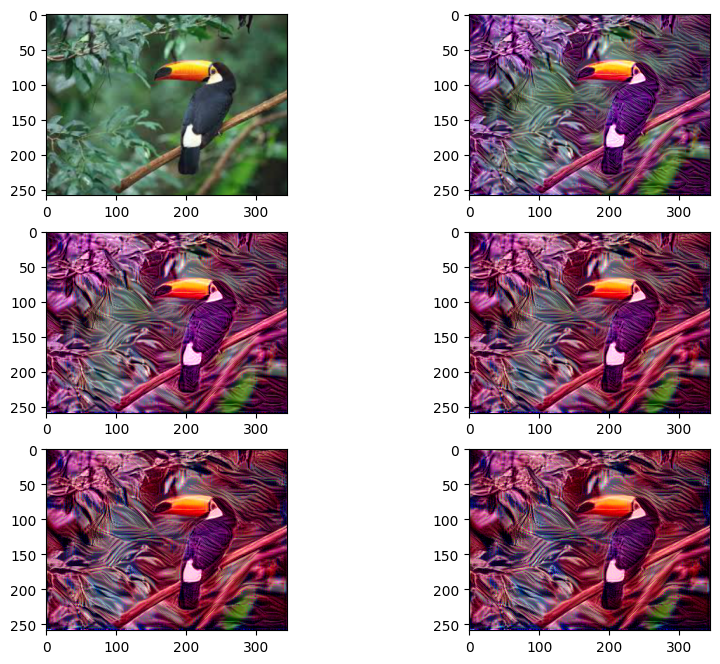

In [ ]:
plt.figure(figsize=(10,8))
for i in range (len(results)):
  plt.subplot(3,2,i+1)
  plt.imshow(results[i])
plt.show()

In [ ]:
target_copy=deprocess(target.detach())
content_copy=deprocess(content_p)

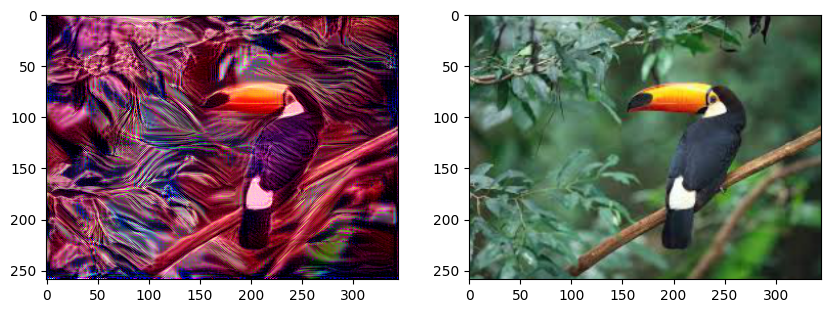

In [ ]:
# display the images
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
# content and style ims side-by-side
ax1.imshow(target_copy)
ax2.imshow(content_copy)